<a href="https://colab.research.google.com/github/Kyeongbin-Tom/logp-tpsa-analysis/blob/main/notebooks/LogP_TPSA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 Project Overview

This project investigates the correlation between molecular lipophilicity (LogP) and topological polar surface area (TPSA) using cheminformatics techniques.

It shows how a chemical hypothesis can be validated by Python-based data analysis using RDKit, and machine learning tools.

## 🛠️ SRC

To keep the notebook concise, modular, and maintainable, we separate reusable fuctions into the `/src` folder.

 - `src/descriptors.py` defines 'smiles_to_descriptors(smiles)', which calculates five molecular descriptors from a SMILES string:
  **TPSA**, **Molecular Weight**, **Number of H-bond Acceptors**, **Number of H-bond Donors**, and **Number of Rotatable Bonds**.

 - `src/visualization.py` contains
  - `plot_distribution(df, col)`: plots a histogram of the descriptors
  - `plot_tpsa_vs_logp(df)`: creates a scatter plot of LogP VS TPSA

## ⚙️ Setup

We configure the environment for compatibility with RDKit and custom modules. RDKit is used for molecular descriptor calculation.NumPy must be downgraded to ≤ 1.23 for RDKit compatibility in Google Colab. We add `/src` to the Python path to enable importing `descriptors.py` and `visualization.py`.

⚠️ **Note**: You may need to restart the runtime after installing RDKit in Colab.

In [ ]:
# ✅ [Setup Step 1] Downgrade numpy (RDKit compatibility fix)
# Must restart Colab runtime after this cell!
!pip install -q numpy==1.26.4

# Force Colab runtime restart
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
# ✅ [Setup Step 2] Install RDKit and load custom Python modules from GitHub

# Install RDKit (after numpy is downgraded)
!pip install -q rdkit-pypi

# Download src/ modules from GitHub
!rm -rf src
!mkdir -p src
!wget -q https://raw.githubusercontent.com/Kyeongbin-Tom/logp-tpsa-analysis/main/src/descriptors.py -O src/descriptors.py
!wget -q https://raw.githubusercontent.com/Kyeongbin-Tom/logp-tpsa-analysis/main/src/visualization.py -O src/visualization.py

# Import functions from src/
import sys
sys.path.append('/content/src')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 21.3 MB/s eta 0:00:00


## 📦 Import Libraries

We import all required libraries for descriptor calculation, visualization, and machine learning model training.

This includes:
- `RDKit` for chemical structure handling
- `pandas`, `matplotlib`, `seaborn` for data analysis and visualization
- `scikit-learn` for modeling and evaluation
- Custom modules from `src/`: `descriptors.py` and `visualization.py`

In [2]:
# Custom modules
from descriptors import smiles_to_descriptors
from visualization import plot_tpsa_vs_logp, plot_distribution

# General-purpose libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


## 📁 Dataset Overview

We use `Lipophilicity.csv` from the CAIP repository, which contains molecular structures represented as SMILES strings along with experimentally measured lipophilicity (LogP) values.

This dataset serves as foundation for feature extraction, correlation analysis, and predictive modeling.

In [3]:
from google.colab import files
uploaded=files.upload()

Saving Lipophilicity.csv to Lipophilicity.csv


In [4]:
# Enter the correct file name (Check auto-generated name!)
df = pd.read_csv("Lipophilicity.csv")

# Check the top 5 rows
df.head()

,SMILES,Lipophilicity
0,Brc1c[nH]c(=NCc2ccccc2)nc1N=c1cc(C2CC2)[nH][nH]1,4.11
1,Brc1cc(Br)cc(COC[C@H](c2ccccc2)N2CCNCC2)c1,2.80
2,C#CC(C)(C)NC(=O)c1sccc1Oc1ccc(F)cc1[N+](=O)[O-],3.00
3,C#CC(C)n1c(=O)c2c(-c3cncn3C)n(Cc3ccnc4ccc(Cl)c...,3.59
4,C#CCC(C(=O)N=C(Cc1cc[nH]c1O)CCC(O)OCC)n1cccc(N...,1.75


## 🧪 Molecular Descriptor Extraction

We calculate the TPSA (Topological Polar Surface Area), which represents the size of the polar region, using RDKit through a custom function `smiles_to_descriptors(smiles)`.

This descriptor will be used as an input for correlation analysis and machine learning. We also check for invalid SMILES strings that may result in missing (NaN) values.

In [5]:
# Calculate TPSA from SMILES using custom descriptor function
df['TPSA'] = df['SMILES'].apply(smiles_to_descriptors)

# Check for any NaN values (invalid SMILES)
print("Missing TPSA values:", df['TPSA'].isna().sum())

Missing TPSA values: 0


In [6]:
# Load the dataset
df = pd.read_csv("Lipophilicity.csv")

# Generate molecular descriptors (TPSA, MolWt, HBD, HBA, RotatableBonds) from SMILES
desc_df = df['SMILES'].apply(smiles_to_descriptors).apply(pd.Series)

# Merge descriptors into original dataframe
df = pd.concat([df, desc_df], axis=1)

# Remove duplicate columns if the cell is re-run
df = df.loc[:, ~df.columns.duplicated()]

In [24]:
# Convert SMILES strings to RDKit Mol objects
df["Mol"] = df["SMILES"].apply(Chem.MolFromSmiles)

# Define a function to compute molecular descriptors from a Mol object
def compute_descriptors(mol):
    if mol is None:
        # Return NaN for all features if Mol object is invalid
        return pd.Series({
            "MolWt": None,
            "TPSA": None,
            "NumHDonors": None,
            "NumHAcceptors": None,
            "NumRotatableBonds": None,
            "RingCount": None,
            "AromaticProportion": None
        })

    # Compute and return molecular descriptors using RDKit
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),  # Molecular weight
        "TPSA": rdMolDescriptors.CalcTPSA(mol),  # Topological polar surface area
        "NumHDonors": rdMolDescriptors.CalcNumHBD(mol),  # Number of H-bond donors
        "NumHAcceptors": rdMolDescriptors.CalcNumHBA(mol),  # Number of H-bond acceptors
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),  # Number of rotatable bonds
        "RingCount": rdMolDescriptors.CalcNumRings(mol),  # Number of rings
        "AromaticProportion": len([atom for atom in mol.GetAromaticAtoms()]) / mol.GetNumAtoms()  # Ratio of aromatic atoms
    })

# Apply the descriptor function to all molecules and create a new DataFrame
descriptor_df = df["Mol"].apply(compute_descriptors)

# Concatenate original dataframe with the descriptor dataframe
df_full = pd.concat([df, descriptor_df], axis=1)

## 📈 Feature Distribution

We plot histograms for each descriptor of distribution and correlation for LogP and TPSA to explore their distribution, range, and variance.

A scatter plot of TPSA versus LogP reveals a potential negative correlation. Pearson correlation coefficient between LogP and TPSA is approximately -0.14.

The plot is saved as images/tpsa_vs_logp.png for use in the README.

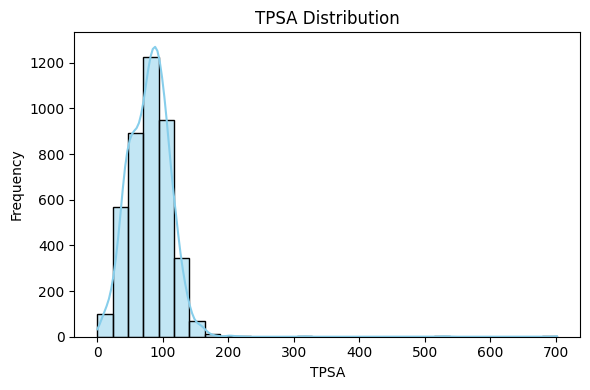

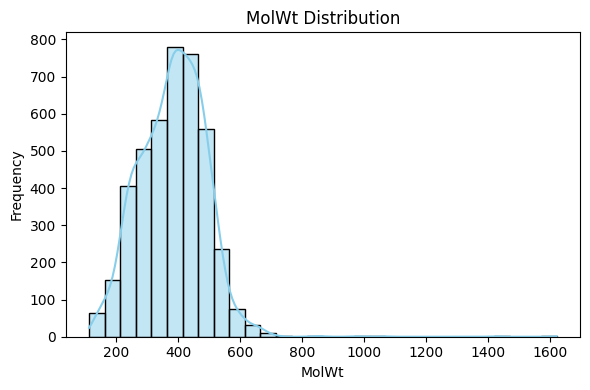

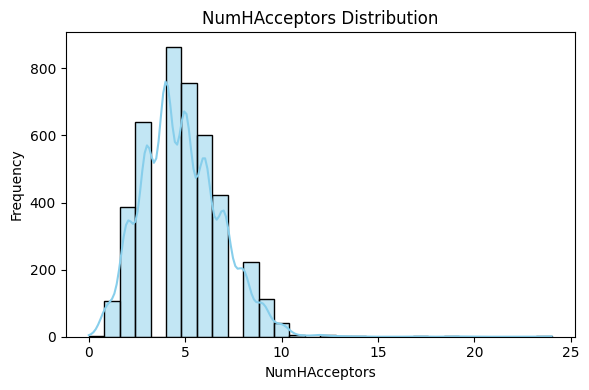

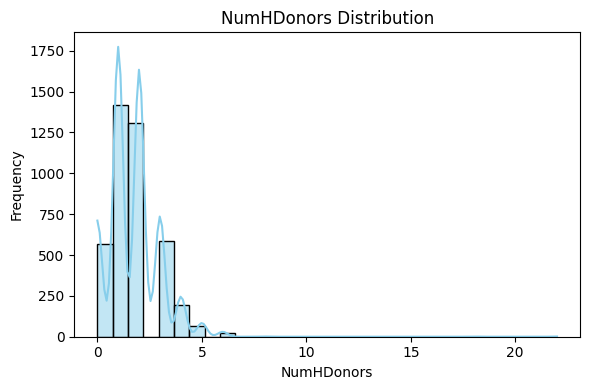

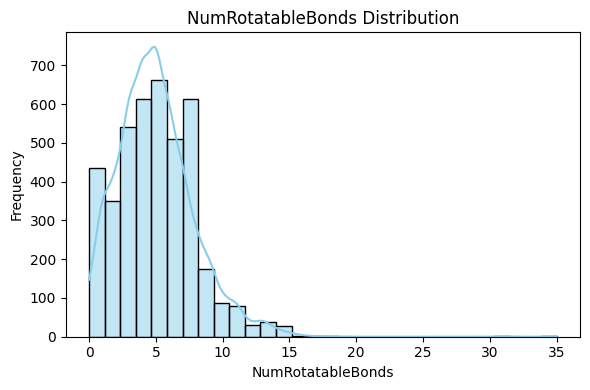

In [7]:
# Plot distribution histograms for each molecular descriptor
for col in ['TPSA', 'MolWt', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds']:
    plot_distribution(df, col, title=f"{col} Distribution")

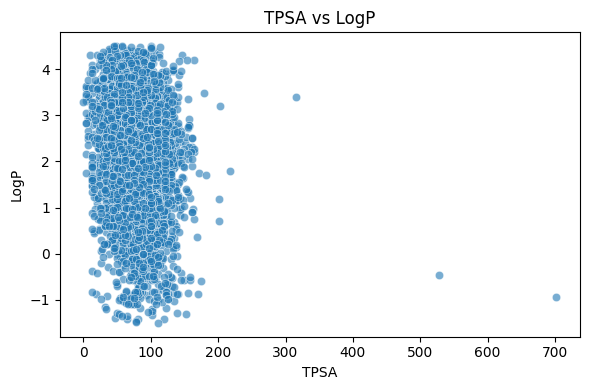

In [8]:
# Scatter plot: TPSA vs LogP
os.makedirs('images', exist_ok=True)
plot_tpsa_vs_logp(
    df,
    save_path='images/tpsa_vs_logp.png'
)

In [9]:
# Check Pearson correlation between TPSA and Lipophilicity
df[['TPSA', 'Lipophilicity']].corr(method='pearson')

,TPSA,Lipophilicity
TPSA,1.000000,-0.142139
Lipophilicity,-0.142139,1.000000


## 🤖 LogP Prediction using Linear Regression

In [40]:
# Define input features and target variable
X = df_full[["MolWt", "TPSA", "NumHDonors", "NumHAcceptors",
             "NumRotatableBonds", "RingCount", "AromaticProportion"]]
y = df_full["Lipophilicity"]

# Split the data into training and testing sets (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict lipophilicity values on the test set
y_pred_lr = lr_model.predict(X_test)

## 🤖 LogP Prediction using SVR



In [41]:
# Create an SVR model with StandardScaler in a pipeline
svr_model = make_pipeline(StandardScaler(), SVR())

# Train the model on the training data
svr_model.fit(X_train, y_train)

# Predict lipophilicity values on the test set
y_pred_svr = svr_model.predict(X_test)

## 🤖 LogP Prediction using Random Forest Regressor

In [42]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict lipophilicity values on the test set
y_pred_rf = rf_model.predict(X_test)

## 📊 Exploratory Data Analysis

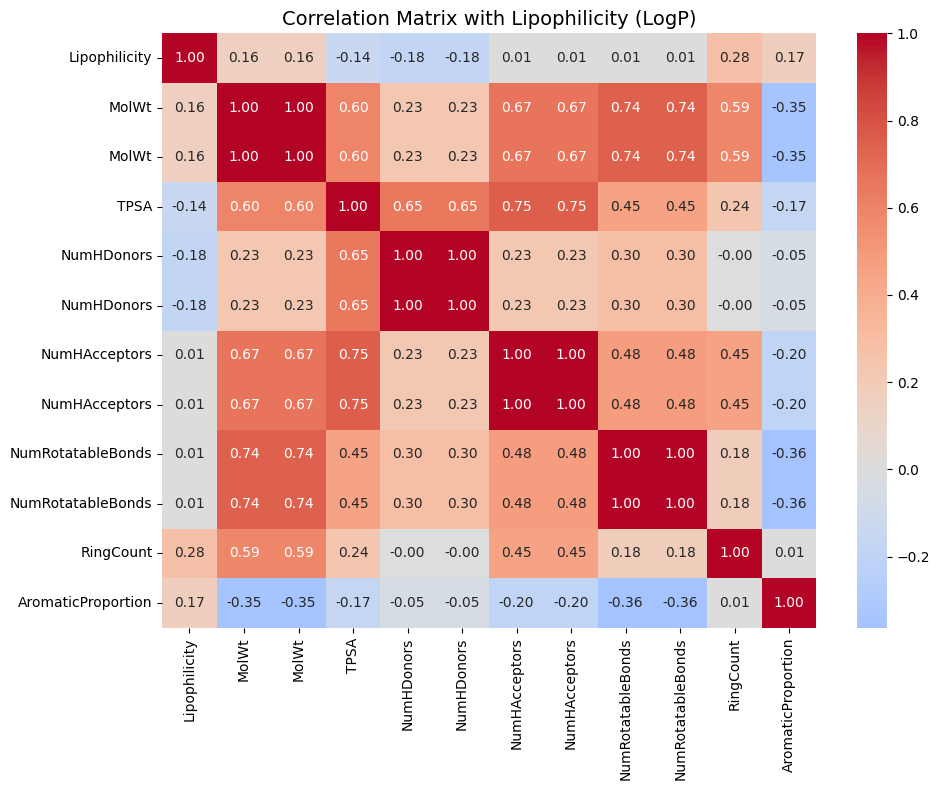

In [37]:
# Correlation Heatmap between Lipophilicity and Descriptors

# Merge the main dataframe with the calculated descriptors
df_full = pd.concat([df, desc_df], axis=1)

# Define all possible descriptor columns to include in the correlation matrix
all_possible_cols = [
    "Lipophilicity", "MolWt", "TPSA",
    "NumHDonors", "NumHAcceptors",
    "NumRotatableBonds", "RingCount", "AromaticProportion"
]

# Select only the columns that exist in the current dataframe
numeric_cols = [col for col in all_possible_cols if col in df_full.columns]

# Compute the correlation matrix
corr_matrix = df_full[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix with Lipophilicity (LogP)", fontsize=14)
plt.tight_layout()
plt.show()

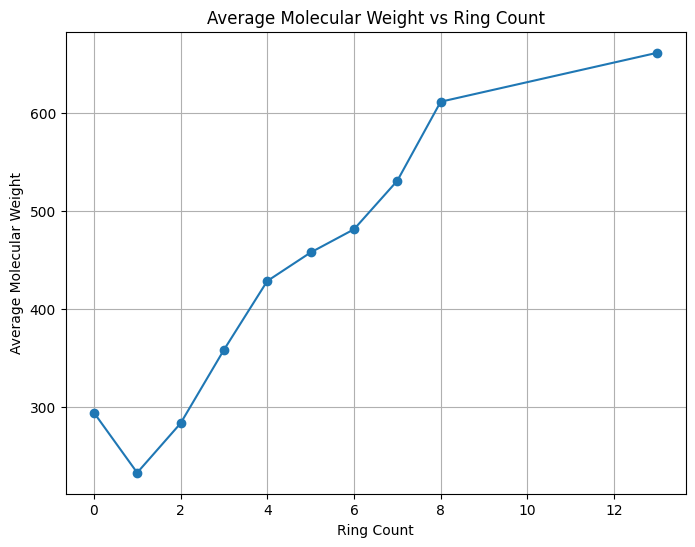

In [38]:
# 1) Read SMILES strings from the CSV file
df = pd.read_csv('Lipophilicity.csv')

# 2) Convert SMILES strings to RDKit Mol objects
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

# 3) Compute descriptors only if the Mol object is not None
df['MolWt'] = df['Mol'].apply(lambda mol: Descriptors.MolWt(mol) if mol is not None else None)
df['RingCount'] = df['Mol'].apply(lambda mol: mol.GetRingInfo().NumRings() if mol is not None else None)

# 4) Optionally remove rows where Mol object creation failed
df = df[df['Mol'].notnull()].copy()

# 5) Calculate average MolWt for each RingCount group
mean_df = df.groupby('RingCount')['MolWt'].mean().reset_index()

# 6) Plot a line graph
plt.figure(figsize=(8,6))
plt.plot(mean_df['RingCount'], mean_df['MolWt'], marker='o', linestyle='-')
plt.title('Average Molecular Weight vs Ring Count')
plt.xlabel('Ring Count')
plt.ylabel('Average Molecular Weight')
plt.grid(True)
plt.show()

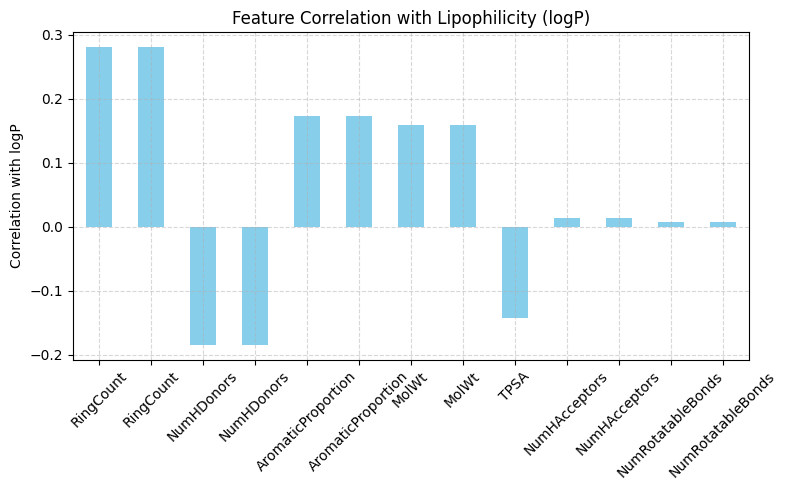

In [39]:
# Set figure size
plt.figure(figsize=(8,5))

# Plot sorted correlation values as a bar chart
logp_corr_sorted.plot(kind='bar', color='skyblue')

# Labeling and styling
plt.ylabel("Correlation with logP")
plt.title("Feature Correlation with Lipophilicity (logP)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

## 📉 Model Evaluation & Interpretation

/tmp/ipython-input-48-2930729357.py:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


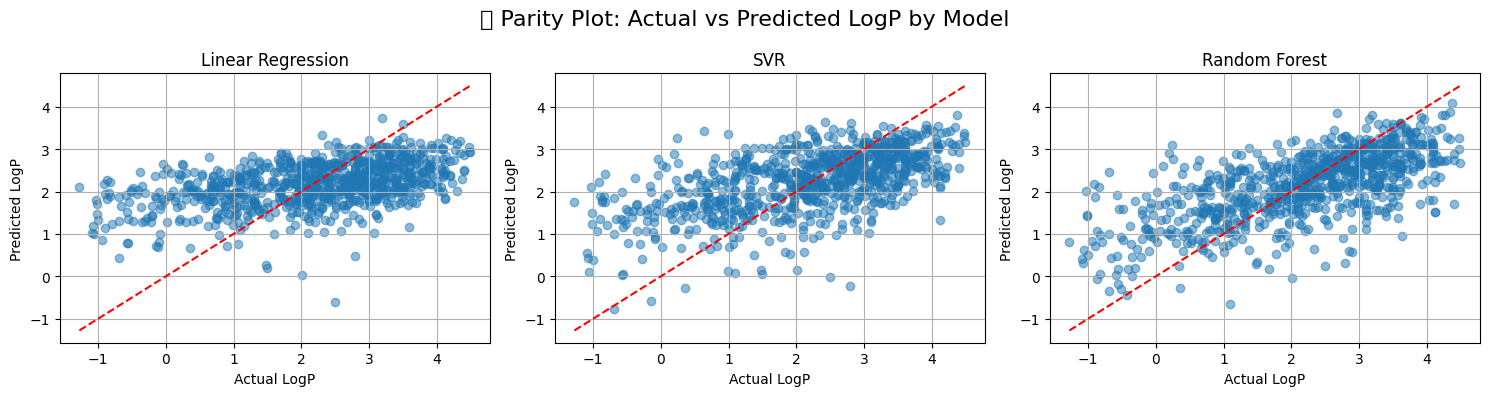

In [48]:
# Define true vs predicted pairs
models = {
    "Linear Regression": (y_test, lr_model.predict(X_test)),
    "SVR": (y_test, y_pred_svr),
    "Random Forest": (y_test, y_pred_rf)
}

# Plot parity plots
plt.figure(figsize=(15, 4))
for i, (name, (y_true, y_pred)) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(f"{name}")
    plt.xlabel("Actual LogP")
    plt.ylabel("Predicted LogP")
    plt.grid(True)

plt.suptitle("🔍 Parity Plot: Actual vs Predicted LogP by Model", fontsize=16)
plt.tight_layout()
plt.show()

In [49]:
# Evaluate all models: Linear Regression, SVR, Random Forest

# Calculate metrics for each model
results = pd.DataFrame({
    "Model": ["Linear Regression", "SVR", "Random Forest"],
    "R² Score": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_svr),
        r2_score(y_test, y_pred_rf)
    ],
    "MSE": [
        mean_squared_error(y_test, y_pred_lr),
        mean_squared_error(y_test, y_pred_svr),
        mean_squared_error(y_test, y_pred_rf)
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_svr),
        mean_absolute_error(y_test, y_pred_rf)
    ]
})

# Print model performance comparison table
print("📊 Model Performance Comparison:")
print(results)

📊 Model Performance Comparison:
               Model  R² Score       MSE       MAE
0  Linear Regression  0.218613  1.262138  0.917513
1                SVR  0.333161  1.077114  0.825512
2      Random Forest  0.439192  0.905847  0.730008
